# Андреев Алексей ИУ5-23М

#### Описание датасета
> Датасет с данными о прокате велосипедов в Лондоне.

Данные в датасете представляют информацию о погодных условиях, дате/времени и количестве велосипедов взятых на прокат в Лондоне за несколько лет

#### Описание колонок
Год — год, когда велосипед взят в аренду.

Месяц — месяц, когда велосипед взят в аренду.

День — день, когда велосипед взят в аренду.

Время — время в часах, когда велосипед взят в аренду.

Количество велосипедов — количество велосипедов, которые были взяты напрокат.

Температура воздуха  — температура воздуха в градусах Цельсия.

Ощущаемая температура — температура воздуха, ощущаемую человеком в градусах Цельсия.

Влажность воздуха — текущую влажность воздуха, выраженную в процентах.

Скорость ветра — скорость ветра в километрах в час.

Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана

Выбранный день - праздничный — 1 если праздничный день.

Выбранный день день - 1 если выходной.

Время года — 0-весна; 1-лето; 2-осень; 3-зима.


In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
data = pd.read_csv("london_merged.csv")

data['year'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).year))
data['month'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).month))
data['day'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).day))
data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))

data['year_month'] = pd.DataFrame(data['timestamp'].apply(lambda x: str(pd.to_datetime(x).year)+'_'+str(pd.to_datetime(x).month) ))

data.head(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,year_month
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0,2015_1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1,2015_1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,2,2015_1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,3,2015_1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4,2015_1


In [20]:
list(zip(
    [i for i in data.columns],
    [str(i) for i in data.dtypes],
    [i for i in data.isnull().sum()]
))

[('timestamp', 'object', 0),
 ('cnt', 'int64', 0),
 ('t1', 'float64', 0),
 ('t2', 'float64', 0),
 ('hum', 'float64', 0),
 ('wind_speed', 'float64', 0),
 ('weather_code', 'float64', 0),
 ('is_holiday', 'float64', 0),
 ('is_weekend', 'float64', 0),
 ('season', 'float64', 0),
 ('year', 'int64', 0),
 ('month', 'int64', 0),
 ('day', 'int64', 0),
 ('hour', 'int64', 0),
 ('year_month', 'object', 0)]

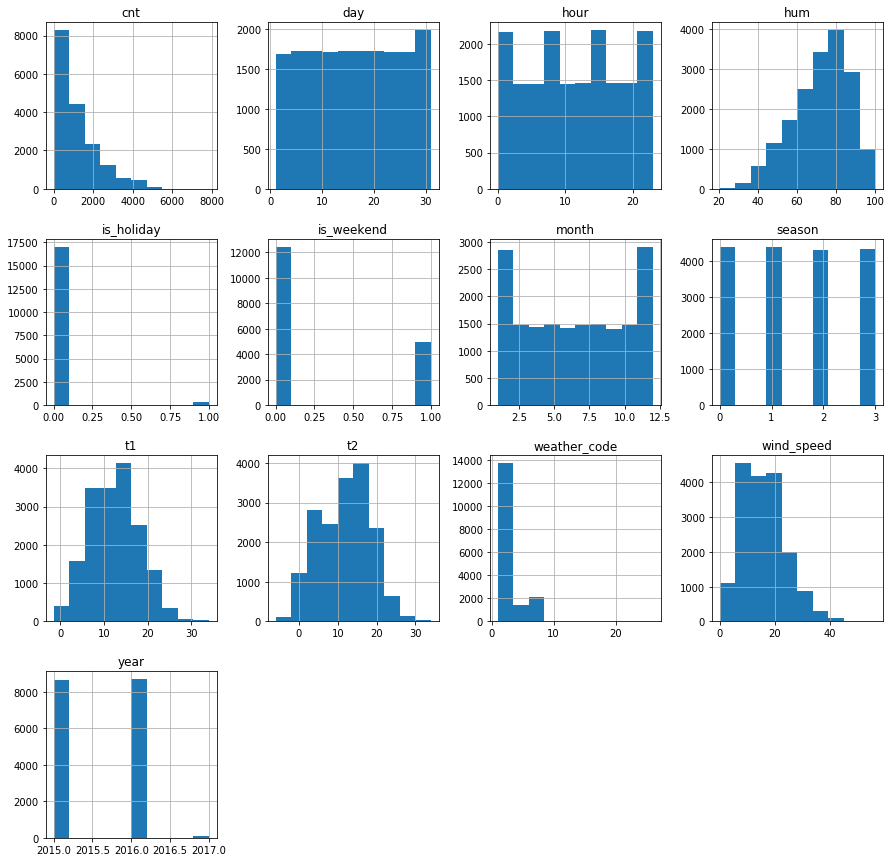

In [22]:
data.hist(figsize=(15,15));

## ШАГ 1

Спрос проката велосипедов в разные месяцы в течении двух лет

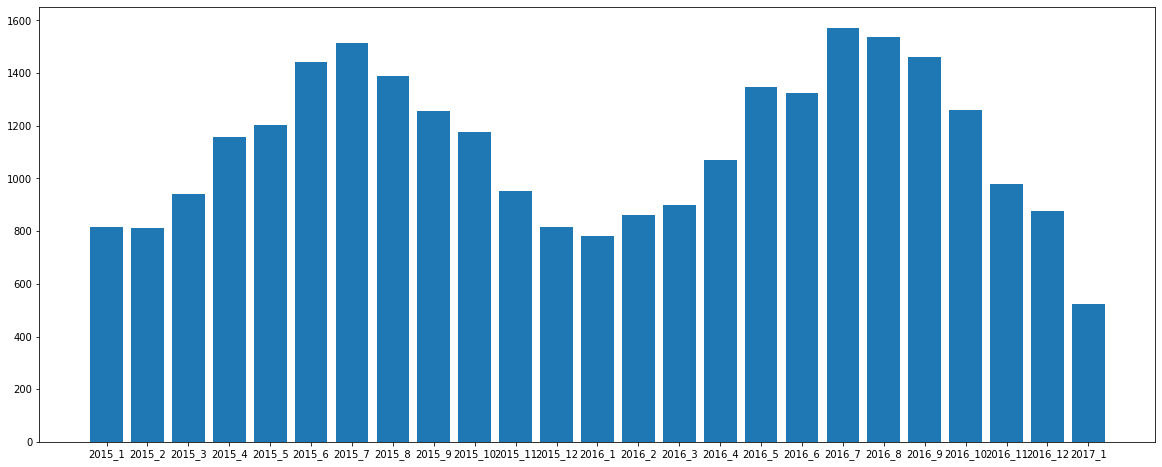

In [36]:
cnt_avg = []
year_month_list = data['year_month'].unique()
for year_month in year_month_list:
    cnt_avg.append(int(
        data[data['year_month']==year_month]['cnt'].mean()
))  

height = cnt_avg
bars = year_month_list
y_pos = np.arange(len(bars))

plt.figure(figsize=(20,8))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

Спрос на прокат велосипедов отличен в каждом месяце. Заметна закономерность, что спрос выше при приближении к лету.

Самый маленький спрос - зимой.

Также можно сделать вывод, что за год выросла актуальность велопроката. В 2016 году велопрокатом пользовались чуть больше чем в 2015 году, что говорит об успешности бизнеса велопроката.

Посмотрим на схожий график, который описывает среднюю температуру за месяц за эти два года.

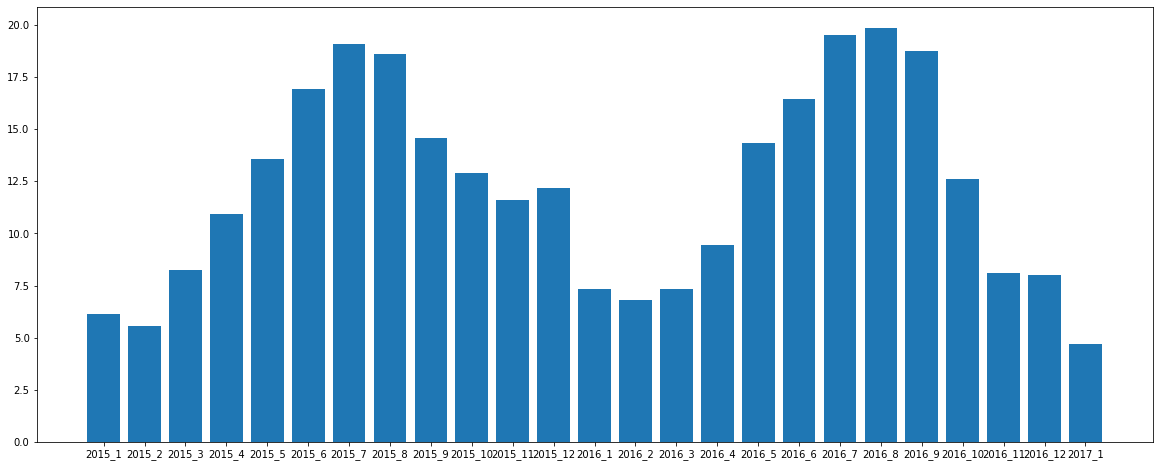

In [37]:
# Средняя температура в каждом месяце года
t1_avg = []
year_month_list = data['year_month'].unique()
for year_month in year_month_list:
    t1_avg.append(data[data['year_month']==year_month]['t1'].mean())

height = t1_avg
bars = year_month_list
y_pos = np.arange(len(bars))

plt.figure(figsize=(20,8))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

И последних двух графиков можно сделать вывод, что температура в течение месяца сильно скореллирована с тем, сколько велосипедов берётся на прокат.

# ШАГ 2

В датасете два похожих столбца: температура воздуха и ощущаемая температура. Нужно определить, какое из этих значение больше влияет на количество велосипедов взятых в прокат. Первое предположение - ощущаемая температура сильнее влияет на целевой признак.

In [38]:
data.corr()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour
cnt,1.000000,0.388798,0.369035,-0.462901,0.116295,-0.166633,-0.051698,-0.096499,-0.116180,0.010046,0.063757,-0.017887,0.324423
t1,0.388798,1.000000,0.988344,-0.447781,0.145471,-0.097114,-0.042233,-0.005342,-0.285851,-0.037959,0.332712,0.005072,0.168708
t2,0.369035,0.988344,1.000000,-0.403495,0.088409,-0.098385,-0.040051,-0.008510,-0.285900,-0.044972,0.368366,0.006791,0.153956
hum,-0.462901,-0.447781,-0.403495,1.000000,-0.287789,0.334750,0.032068,0.028098,0.290381,0.072443,0.113149,-0.020868,-0.295653
wind_speed,0.116295,0.145471,0.088409,-0.287789,1.000000,0.124803,-0.002606,0.011479,0.010305,-0.094739,-0.086383,0.002040,0.141792
weather_code,-0.166633,-0.097114,-0.098385,0.334750,0.124803,1.000000,0.012939,0.042362,0.098976,-0.009234,-0.033253,0.001904,-0.041786
is_holiday,-0.051698,-0.042233,-0.040051,0.032068,-0.002606,0.012939,1.000000,-0.094898,-0.032488,0.034631,-0.011511,0.042657,-0.000288
is_weekend,-0.096499,-0.005342,-0.008510,0.028098,0.011479,0.042362,-0.094898,1.000000,0.001067,0.003049,-0.005406,0.005721,0.001803
season,-0.116180,-0.285851,-0.285900,0.290381,0.010305,0.098976,-0.032488,0.001067,1.000000,0.024400,0.203249,-0.006460,0.000006
year,0.010046,-0.037959,-0.044972,0.072443,-0.094739,-0.009234,0.034631,0.003049,0.024400,1.000000,-0.026547,-0.021935,0.000542


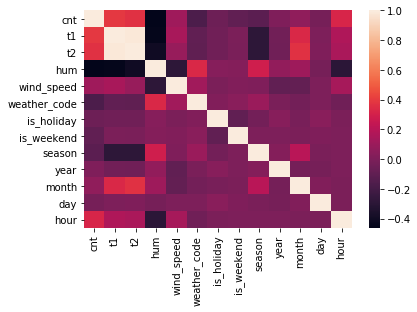

In [40]:
sns.heatmap(data.corr());

Нет большой разницы между ощущаемой температурой и температурой воздуха. Однако, абсолютное значение температуры воздуха имеет большую корреляцию с целевым признаком - значение коэффициента корреляции температуры воздуха и количеством велосипедов равно 0.388, а между ощущаемой температурой и количеством велосипедов равно 0.369.

Делаю вывод, что для обучения модели для определения количества велосипедов, взятых в прокат лучше использовать абсолютное значение температуры воздуха, а не ощущаемую температуру.

# ШАГ 3

Есть большой коэффициент корреляции между влажностью и целевым признаком, равный -0.46.

Проведём исследование того, как влажность зависит от остальных признаков. 

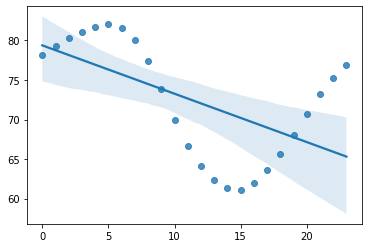

In [57]:
hum_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    hum_avg.append(data[data['hour']==hour]['hum'].mean())

sns.regplot(x=hour_list, y=hum_avg);

Есть зависимость влажности от времени суток.  
Возможно, на влажность действует как время суток, так и температура воздуха. Построим диграмму для трёх параметров.

In [58]:
hum_avg = []
t1_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    hum_avg.append(data[data['hour']==hour]['hum'].mean())
    t1_avg.append(data[data['hour']==hour]['t1'].mean())
    
df_for_scatterplot = pd.DataFrame(zip(hum_avg, t1_avg, hour_list),
                                  columns=['hum_avg', 't1_avg', 'hour'])
df_for_scatterplot[:5]

,hum_avg,t1_avg,hour
0,78.138467,11.239641,0
1,79.301796,10.976289,1
2,80.303745,10.741331,2
3,81.077670,10.531900,3
4,81.670596,10.357143,4


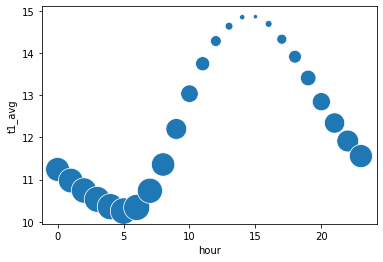

In [59]:
sns.scatterplot(data=df_for_scatterplot,
                x='hour',
                y='t1_avg',
                size='hum_avg',
                legend=False,
                sizes=(20, 700))
plt.show()

Влажность тем ниже, чем выше температура, при этом температура повышается в дневной период с 10 до 20 часов.

Можно сделать вывод, что количество велосипедов в прокате повышается в дневное время, и в это же время понижается влажность и повышается температура, благодаря чему люди предпочитают взять в прокат велосипед именно в это время.

# ШАГ 4

Делаю предположение, что в праздничные дни в прокате находится больше велосипедов.

In [62]:
data_is_holiday = data[data['is_holiday']==1]
data_not_holiday = data[data['is_holiday']==0]

# всего 384/24 = 16 праздничных дней за 2 года
data_is_holiday

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,year_month
2129,2015-04-03 00:00:00,279,8.0,6.0,82.0,10.0,7.0,1.0,0.0,0.0,2015,4,3,0,2015_4
2130,2015-04-03 01:00:00,174,8.0,5.5,79.0,14.0,7.0,1.0,0.0,0.0,2015,4,3,1,2015_4
2131,2015-04-03 02:00:00,89,7.5,5.5,84.5,12.0,7.0,1.0,0.0,0.0,2015,4,3,2,2015_4
2132,2015-04-03 03:00:00,61,7.0,5.0,87.0,11.0,7.0,1.0,0.0,0.0,2015,4,3,3,2015_4
2133,2015-04-03 04:00:00,46,7.0,6.0,93.0,6.0,7.0,1.0,0.0,0.0,2015,4,3,4,2015_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17385,2017-01-02 19:00:00,433,3.0,0.0,81.0,11.0,1.0,1.0,0.0,3.0,2017,1,2,19,2017_1
17386,2017-01-02 20:00:00,334,3.0,0.0,75.0,13.0,1.0,1.0,0.0,3.0,2017,1,2,20,2017_1
17387,2017-01-02 21:00:00,233,2.5,-0.5,78.0,11.0,1.0,1.0,0.0,3.0,2017,1,2,21,2017_1
17388,2017-01-02 22:00:00,201,2.0,-1.0,81.0,10.0,1.0,1.0,0.0,3.0,2017,1,2,22,2017_1


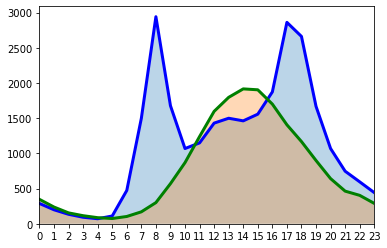

In [63]:
cnt_avg_is_holiday = []
cnt_avg_not_holiday = []
hour_list = data['hour'].unique()
for hour in hour_list:
    cnt_avg_is_holiday.append(int(data_is_holiday[data_is_holiday['hour']==hour]['cnt'].mean()))
    
for hour in hour_list:
    cnt_avg_not_holiday.append(int(data_not_holiday[data_not_holiday['hour']==hour]['cnt'].mean()))

    
fig, ax = plt.subplots()
ax.plot(hour_list, cnt_avg_not_holiday, color='blue', lw=3)
ax.plot(hour_list, cnt_avg_is_holiday, color='green', lw=3)
ax.fill_between(hour_list, 0, cnt_avg_not_holiday, alpha=.3)
ax.fill_between(hour_list, 0, cnt_avg_is_holiday, alpha=.3)
ax.set(xlim=(0, len(hour_list) - 1), ylim=(0, None), xticks=hour_list)

# Show the graph
plt.show()

Диаграмма выше показывает количество взятых велосипедов в зависимости от времени.

Синий график - количество велосипедов взятых в обычные дни.

Зеленый график - количество велосипедов взятых в празднчиные дни.


Делаю вывод: в обычные (в основном будние) дни люди берут на прокат велосипеды утром и вечером (едут на работу и с работы). В праздничные дни пик велопроката в 14-15 часов (при этом не намного больше, чем в обычные дни), а утром и вечером в праздничные дни мало велосипедов находится в прокате.

# ШАГ 5

Теперь проведём анализ проката велосипедов относительно погодных условий.


Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана.

In [65]:
avg_cnt_for_weather = []
codes = [1,2,3,4,7,10,26,94]
for code in codes:
    avg_cnt_for_weather.append(data[data['weather_code'] == code]['cnt'].mean())
    
avg_cnt_for_weather.remove(np.NaN)
print(avg_cnt_for_weather)

[1162.0889430894308, 1496.1774913237482, 1195.124471979724, 635.2308743169399, 712.9663708547408, 583.4285714285714, 250.85]


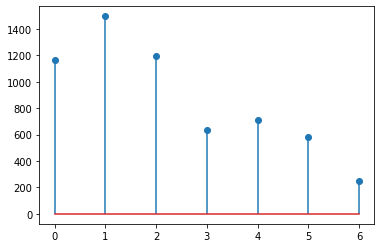

In [71]:
plt.stem(avg_cnt_for_weather, use_line_collection=True);
# Где
# 0 - Ясно
# 1 - Кучевые облака
# 2 - Перистые облака
# 3 - Облачно
# 4 - Дождь
# 5 - Дождь с грозой
# 6 - Снегопад

Большое количество людей предпочитают брать велосипеды во время небольших облаков (1 Кучевые облака), а не когда их совсем нет (0 Ясно). Возможно это связано с тем, что во время солнечных дней кататься не очень комфортно.


При облачной погоде (3 Облачно) количество людей, которые арендуют велосипед резко уменьшается. Дождь (4) и дождь с грозой (5) равносильны облачной погоде (примерно в 2 раза меньше чем при ясной или слабо облачной погоде)